In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
!pip install scikeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor

import warnings
warnings.filterwarnings("ignore")




ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Load data
df = pd.read_csv("walmart.csv")
df.drop_duplicates(inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

In [ ]:
# Features and target
X = df.drop(columns=["Weekly_Sales"])
y = df["Weekly_Sales"]

In [ ]:

# One-hot encoding for categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# -------------------- Linear Regression --------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# -------------------- Random Forest Tuning --------------------
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=3, scoring='r2', n_jobs=-1, random_state=42)
rf_search.fit(X_train_scaled, y_train)
rf_best = rf_search.best_estimator_


In [ ]:
# -------------------- XGBoost Tuning --------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=3, scoring='r2', n_jobs=-1, random_state=42)
xgb_search.fit(X_train_scaled, y_train)
xgb_best = xgb_search.best_estimator_

In [ ]:
# -------------------- Support Vector Regression --------------------
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

SVR()

In [ ]:
# -------------------- Keras Neural Network --------------------
def build_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Fix: Use build_fn instead of model param
nn = KerasRegressor(build_fn=build_model, epochs=50, batch_size=32, verbose=0)
nn.fit(X_train_scaled, y_train)

# Predict to use in stacking model input
fnn_train_preds = nn.predict(X_train_scaled)
fnn_test_preds = nn.predict(X_test_scaled)

# Add FNN predictions as additional feature
X_train_stacked = np.hstack([X_train_scaled, fnn_train_preds.reshape(-1, 1)])
X_test_stacked = np.hstack([X_test_scaled, fnn_test_preds.reshape(-1, 1)])

In [ ]:
# -------------------- Stacking Regressor --------------------

fnn_train_preds = nn.predict(X_train_scaled)
fnn_test_preds = nn.predict(X_test_scaled)

X_train_stacked = np.hstack([X_train_scaled, fnn_train_preds.reshape(-1, 1)])
X_test_stacked = np.hstack([X_test_scaled, fnn_test_preds.reshape(-1, 1)])

stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_best),
        ('rf', rf_best)
    ],
    final_estimator=LinearRegression()
)
stacking_model.fit(X_train_stacked, y_train)


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=20,
                                                     min_samples_split=5,
                                                     random_state=42))],
                  final_estimator=LinearRegression())

In [ ]:
def regression_accuracy(y_true, y_pred, tolerance=0.15):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    within_tolerance = np.abs((y_true - y_pred) / y_true) <= tolerance
    return np.mean(within_tolerance)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
def evaluate_model(model, name, X_tr, X_te):
    y_train_pred = model.predict(X_tr)
    y_test_pred = model.predict(X_te)

    return {
        "Model": name,
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train MSE": mean_squared_error(y_train, y_train_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
        "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred),
        "Test MAPE": mean_absolute_percentage_error(y_test, y_test_pred),
        "Train Accuracy": regression_accuracy(y_train, y_train_pred),
        "Test Accuracy": regression_accuracy(y_test, y_test_pred)
    }


In [ ]:
results = []
results.append(evaluate_model(lin_reg, "Linear Regression", X_train_scaled, X_test_scaled))
results.append(evaluate_model(rf_best, "Random Forest", X_train_scaled, X_test_scaled))
results.append(evaluate_model(xgb_best, "XGBoost", X_train_scaled, X_test_scaled))
results.append(evaluate_model(svr_model, "SVR", X_train_scaled, X_test_scaled))
results.append(evaluate_model(nn, "Neural Network", X_train_scaled, X_test_scaled))
results.append(evaluate_model(stacking_model, "Stacking Regressor", X_train_stacked, X_test_stacked))

# Display as formatted table
results_df = pd.DataFrame(results).sort_values(by="Test R2", ascending=False)

# Round for clean display
numeric_cols = results_df.select_dtypes(include='number').columns
results_df[numeric_cols] = results_df[numeric_cols].applymap(lambda x: f"{x:.6f}")
print("\nModel Performance Comparison:\n")
print(results_df.to_string(index=False))



Model Performance Comparison:

             Model  Train R2   Test R2     Train MAE      Test MAE           Train MSE            Test MSE Train MAPE Test MAPE Train Accuracy Test Accuracy
Stacking Regressor  0.997235  0.965367  20199.182728  57599.366550    877878652.981266  11157333956.508337   2.234777  5.429797       0.997086      0.953380
           XGBoost  0.996846  0.956009  22516.254140  63029.412382   1001525334.139648  14171886393.853851   2.532665  6.107127       0.992813      0.916084
     Random Forest  0.988966  0.936736  33746.372140  74209.494698   3503367955.731647  20380717802.106953   3.014157  6.424450       0.989705      0.914530
 Linear Regression  0.189838  0.156527 421546.941372 434690.335226 257240307338.964447 271728537650.970032  60.012216 62.813682       0.201049      0.195027
    Neural Network  0.175815  0.133646 424405.622207 441561.244703 261692830495.300690 279099837759.768921  60.138802 63.221526       0.204740      0.183372
               SVR -0.0232

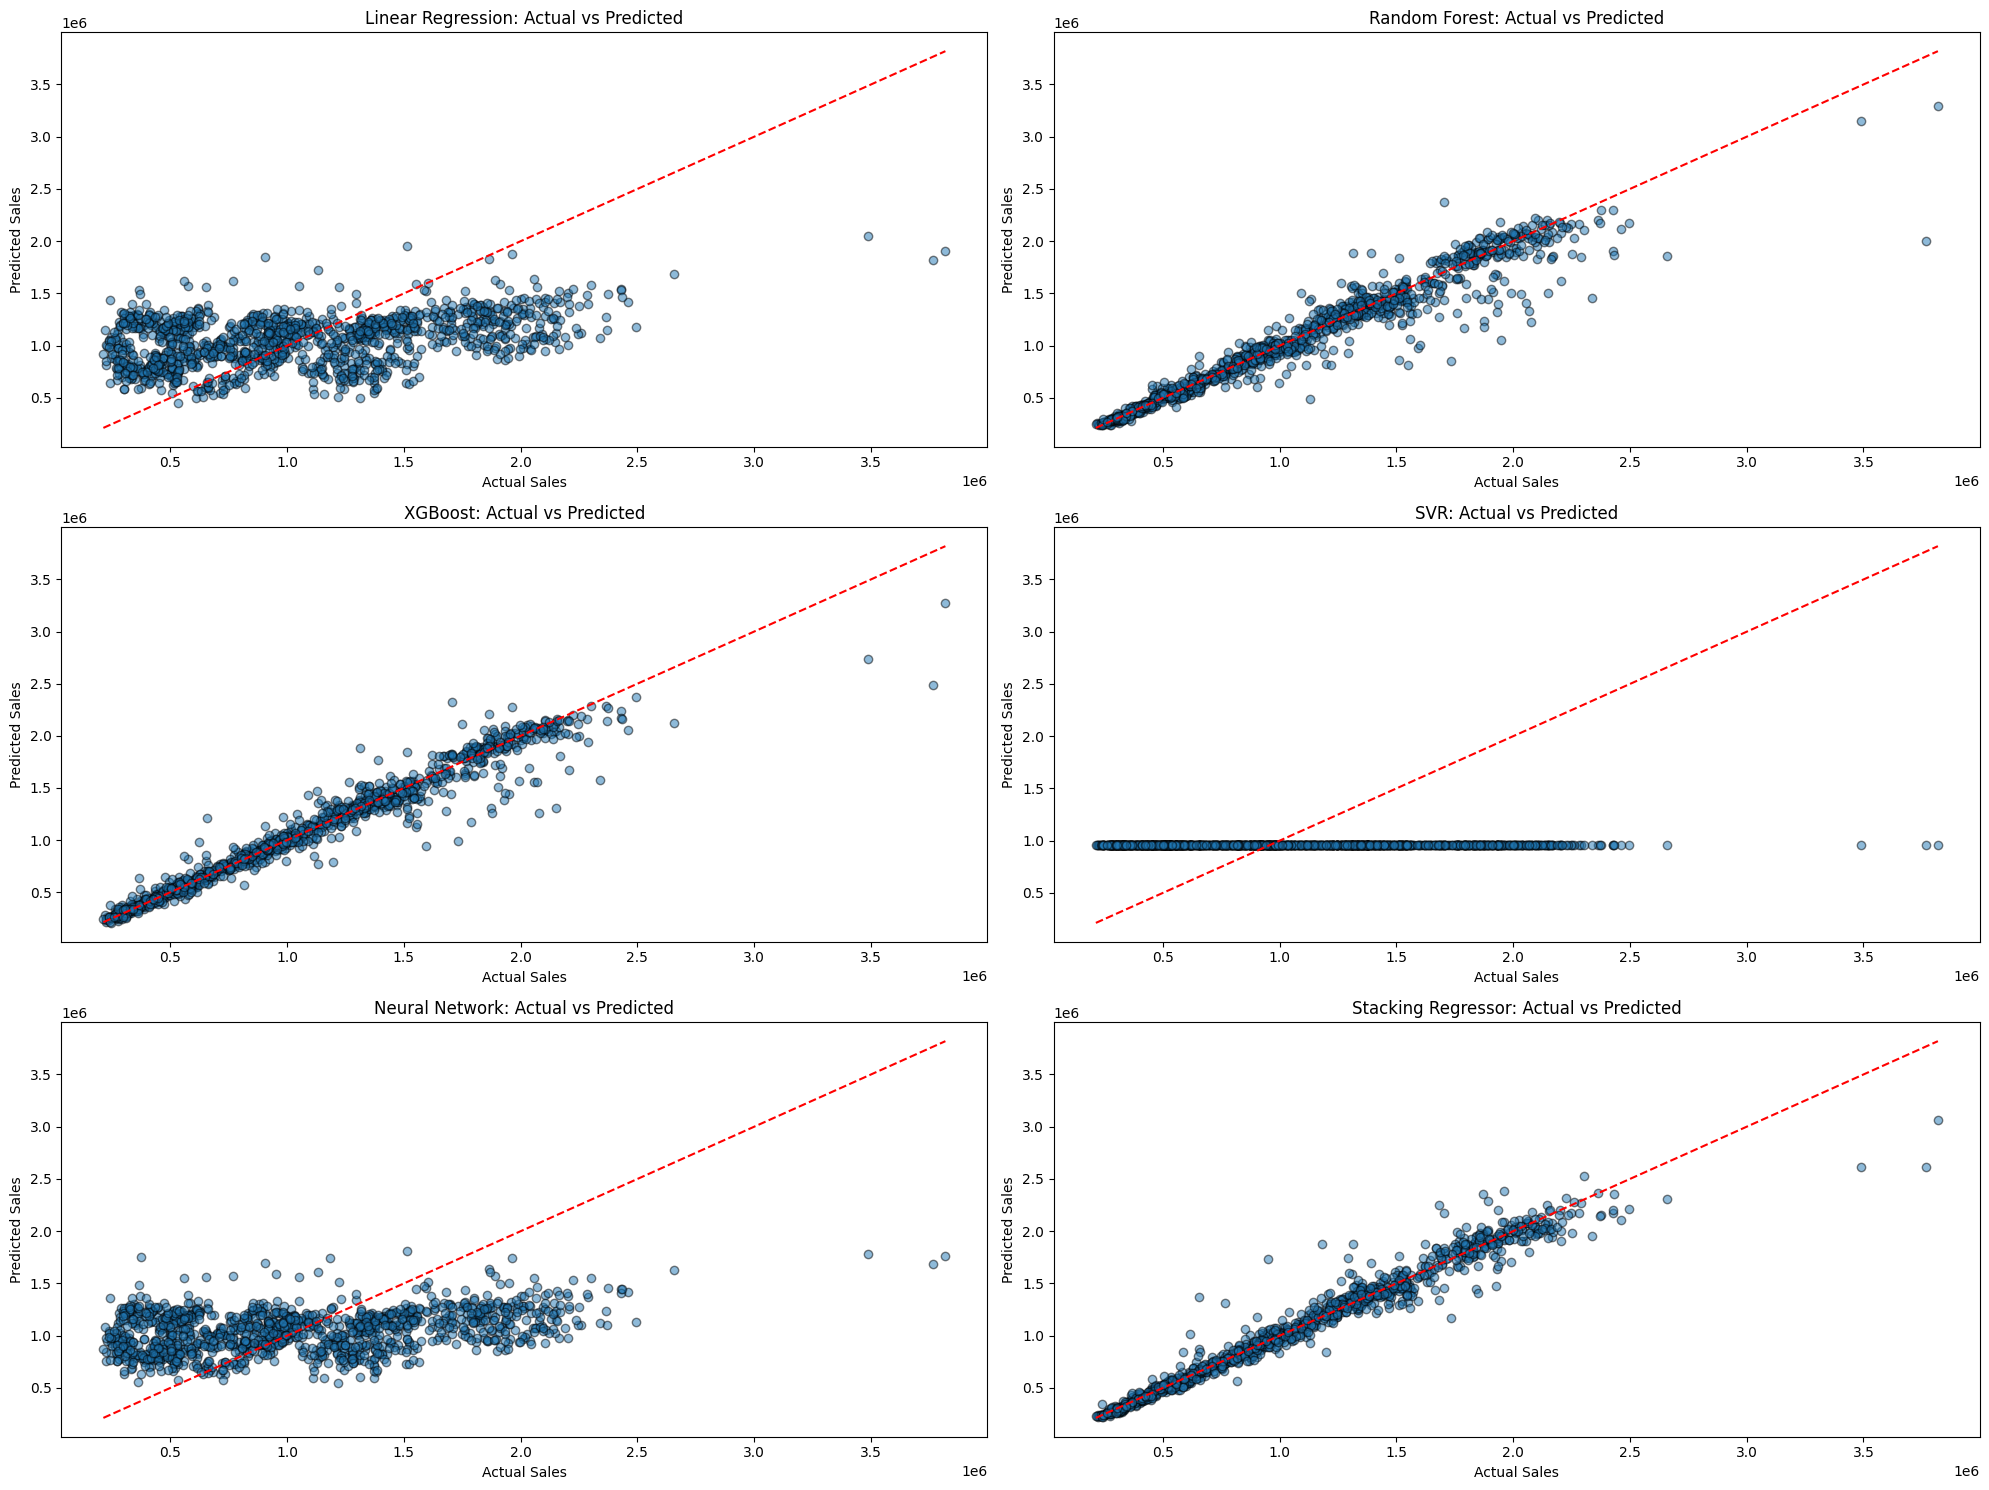

In [ ]:


# -------------------- Plotting Actual vs Predicted for all models --------------------
model_names = [
    (lin_reg, "Linear Regression", X_test_scaled),
    (rf_best, "Random Forest", X_test_scaled),
    (xgb_best, "XGBoost", X_test_scaled),
    (svr_model, "SVR", X_test_scaled),
    (nn, "Neural Network", X_test_scaled),
    (stacking_model, "Stacking Regressor", X_test_stacked)
]

plt.figure(figsize=(20, 15))
for i, (model, name, X_data) in enumerate(model_names, 1):
    y_pred = model.predict(X_data)
    plt.subplot(3, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")

plt.tight_layout()
plt.show()


In [ ]:
import joblib
joblib.dump(stacking_model, 'hyper_tuned_sales_model.pkl')


NameError: name 'stacking_model' is not defined